In [1]:
import ast
import json
import csv
import mapbox
import urllib
import gmplot
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from shapely.geometry import Polygon
from shapely.geometry import Point
from csv import reader
from mapbox import Geocoder
from flask import Flask, request, render_template
from math import radians, degrees, sin, cos, asin, acos, sqrt
from pyproj import Proj

In [2]:
MAPBOX_ACCESS_KEY = 'pk.eyJ1IjoidGxldWNiIiwiYSI6ImNrN2N3d3h1aTA0YWwzaHFoNGJreDJmY2YifQ.pbWSn9txb4n8fKmUaKAG4g'

In [3]:
def great_circle(lat1, lon1, lat2, lon2):
	"""
	This function calculates the shortest distance between two sets of coordinates.
	"""

	lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

	# use 6371 if calculating kilometers (3958.756 for miles)
	return 3958.756 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))

In [4]:
def read_csv():
	"""
	This function reads the polygon csv file and returns the coordinates to create the polygon in mapbox
	to be displayed in the html file.
	"""

	# setting up list
	lat_input = []
	lon_input = []

	# read CSV file but skipped header line in read
	with open('static/polygon.csv', 'r') as read_line:
	    csv_reader = reader(read_line)
	    header = next(csv_reader)
	    # Check file as empty
	    if header != None:
	        # Iterate over each row after the header in the csv
	        for row in csv_reader:
	        	lat_input.append(ast.literal_eval(row[1]))
	        	lon_input.append(ast.literal_eval(row[0]))

	map_output = [[a, b] for a, b in zip(lon_input, lat_input)]

	return map_output

In [5]:
def write_csv(poly):
	"""
	This function writes the active fire intial polygon to csv to be used for the ML model to calculate 
	spread on the next day.
	"""

	with open("static/intial_polygon.csv", "w") as f:
		writer = csv.writer(f)
		writer.writerows(poly)


In [6]:
def convert_point(lat,lon):
    """
    Convert Coordinate Reference systems from map lat/lon to fire raster CRS
    Input: Point of latitude,longitude
    Output: Tuple of (x,y) in CRS coordinates
    """

    # Declare point (longitude (or x) always comes first, then latitude (y))
    point = Point(lon,lat)
    
    # Set Source CRS (Mapbox or Google Maps)
    src_crs = "EPSG:4326"
    
    # create dataframe from input lat/long
    gdf=gpd.GeoDataFrame(index=[0],crs = src_crs, geometry=[point])
        
    # Change CRS to match Wildfire CRS (3857)
    gdf_tf = gdf.to_crs("epsg:3857")
    
    # pull x and y value out from the POINT attribute, then get
    # the value in the data series at row[0]
    x = gdf_tf.geometry.x.at[0]
    y = gdf_tf.geometry.y.at[0]
        
    return (x,y)

In [7]:
def convert_polygon(fire_polygon):
    """Convert Coord ref system (CRS) from fire data (EPSG 3857) to map 
    lat/long (EPSG 4326), polygon starts and ends on same point (to close it)
    
    Input: list containing tuples of x,y points in fire CRS that describe a polygon
    Output: list containing tuples of lat/long points that describe the polygon
    """
    
    # create polygon
    poly = geometry.Polygon([(p[0], p[1]) for p in fire_polygon])
    
    #CRS
    src_crs = "EPSG:3857"
    dst_crs = "EPSG:4326"
    
    # Create Geo DataFrame
    gfp = gpd.GeoDataFrame(index=[0],crs=src_crs,geometry=[poly])
    
    # Convert CRS
    gfp2 = gfp.to_crs(dst_crs)
    
    # pull data from dataframe
    polyout = gfp2.iloc[0]['geometry']
    
    # create list of tuples, but longitude is first
    l = list(map(tuple,np.asarray(polyout.exterior.coords)))
    l = list(map(lambda m: (m[1],m[0]), l))
    
    return l

In [8]:
def get_lat_loc(address):
	"""
	Convert a string of address to latitude and longitude 
	Input: String 
	Output: latitude, longitude coordinate
	"""

	geocoder = mapbox.Geocoder(access_token = MAPBOX_ACCESS_KEY)
	response = geocoder.forward(address)
	address = response.json()
	add_lat = address["features"][0]["center"][1]
	add_lon = address["features"][0]["center"][0]
	return add_lat, add_lon

In [9]:
def points(poly):
    return list(map(tuple,np.asarray(poly.exterior.coords)))

In [256]:
def active_fire(lat_origin, lon_origin):
	"""
	Function to find coordinates of active fires of given origin
	Input: latitude, longitude of input address (origin)
	Output: List of active fires within certain miles of origin
	"""

	# set variables
	lat_geo = []
	lon_geo = []
	geo_center = []

	# # read JSON on active fire
	# url = 'https://www.fire.ca.gov/umbraco/api/IncidentApi/List?inactive=true'
	# geo_data = requests.get(url).json()

	# # loop through list provided by Cal Fire and find active fire within certain miles of origin
	# for i in range(0,len(geo_data)):
	#     if geo_data[i]['IsActive'] == "Y":
	#         fire_lat = geo_data[i]['Latitude']
	#         fire_lon = geo_data[i]['Longitude']
	#         dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)
	#         if dist <= 100:
	#         	lat_geo.append(fire_lat)
	#         	lon_geo.append(fire_lon)

	# geo_center = [[a, b] for a, b in zip(lon_geo, lat_geo)]

	# geo_center = [[-121.9230432, 36.52439536]]

	# return geo_center

	# read JSON on active fire
	url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
	# geo_data = requests.get(url).json()	
	geo_data = gpd.read_file(url)

	poly_list = geo_data.geometry

	for i in range(0,len(poly_list)):

		if len(geo_center) > 0:
			break

		if poly_list[i].geom_type == 'MultiPolygon':

			for j in range(0, len(poly_list[i])):

				geo_poly = points(poly_list[i][j])

				for k in range(0, len(geo_poly)):

					fire_lon = geo_poly[k][0]
					fire_lat = geo_poly[k][1]

					dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

					if dist <= 100:
						geo_center = [fire_lon, fire_lat]
						break

				if len(geo_center) > 0:
					break

			if len(geo_center) > 0:
				break

		else:

			geo_poly = points(poly_list[i])

			for j in range(0, len(geo_poly)):

				fire_lon = geo_poly[j][0]
				fire_lat = geo_poly[j][1]

				dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

				if dist <= 100:
					geo_center = [fire_lon, fire_lat]
					break

			if len(geo_center) > 0:
				break

		if len(geo_center) > 0:
			break
		else:
			geo_poly =[]
			break

	return geo_center, geo_poly

In [16]:
def active_fire(lat_origin, lon_origin):
	"""
	Function to find coordinates of active fires of given origin
	Input: latitude, longitude of input address (origin)
	Output: List of active fires within certain miles of origin
	"""

	# set variables
	lat_geo = []
	lon_geo = []
	geo_center = []
	geo_fire = []

	# # read JSON on active fire
	# url = 'https://www.fire.ca.gov/umbraco/api/IncidentApi/List?inactive=true'
	# geo_data = requests.get(url).json()

	# # loop through list provided by Cal Fire and find active fire within certain miles of origin
	# for i in range(0,len(geo_data)):
	#     if geo_data[i]['IsActive'] == "Y":
	#         fire_lat = geo_data[i]['Latitude']
	#         fire_lon = geo_data[i]['Longitude']
	#         dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)
	#         if dist <= 100:
	#         	lat_geo.append(fire_lat)
	#         	lon_geo.append(fire_lon)

	# geo_center = [[a, b] for a, b in zip(lon_geo, lat_geo)]

	# geo_center = [[-121.9230432, 36.52439536]]

	# return geo_center

	# read JSON on active fire
	url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
	# geo_data = requests.get(url).json()	
	geo_data = gpd.read_file(url)

	poly_list = geo_data.geometry

	# grab the first coordinates of all polygons to create list of active fires

	for m in range(0,len(poly_list)):

		if poly_list[m].geom_type == 'MultiPolygon':

			geo_poly = points(poly_list[m][0])

			fire_lon = geo_poly[0][0]
			fire_lat = geo_poly[0][1]

			lat_geo.append(fire_lat)
			lon_geo.append(fire_lon)

		else:

			geo_poly = points(poly_list[m])

			fire_lon = geo_poly[0][0]
			fire_lat = geo_poly[0][1]

			lat_geo.append(fire_lat)
			lon_geo.append(fire_lon)

	geo_fire = [[a, b] for a, b in zip(lon_geo, lat_geo)]

	geo_poly = []

	for i in range(0,len(poly_list)):

		if len(geo_center) > 0:
			break

		if poly_list[i].geom_type == 'MultiPolygon':

			for j in range(0, len(poly_list[i])):

				geo_poly = points(poly_list[i][j])

				for k in range(0, len(geo_poly)):

					fire_lon = geo_poly[k][0]
					fire_lat = geo_poly[k][1]

					dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

					if dist <= 100:
						geo_center = [fire_lon, fire_lat]
						break

				if len(geo_center) > 0:
					break

			if len(geo_center) > 0:
				break

		else:

			geo_poly = points(poly_list[i])

			for j in range(0, len(geo_poly)):

				fire_lon = geo_poly[j][0]
				fire_lat = geo_poly[j][1]

				dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

				if dist <= 100:
					geo_center = [fire_lon, fire_lat]
					break

			if len(geo_center) > 0:
				break

		if len(geo_center) > 0:
			break
		else:
			geo_poly =[]
			break

	return geo_center, geo_poly, geo_fire

In [18]:
add_lat = 26.16637548
add_lon = -81.2183

# add_lat = 20.8381
# add_lon = -89.086

In [24]:
cnn_poly =[]

In [19]:
geo_center, geo_poly, geo_fire = active_fire(add_lat, add_lon)

In [20]:
geo_center

[]

In [21]:
geo_poly

[]

In [22]:
geo_fire

[[-101.238081688, 43.381299852],
 [-101.440561754, 35.6902790170001],
 [-82.059867131, 39.4841185070001],
 [-102.009208374, 43.478397638],
 [-81.218376301, 26.1663754840001],
 [-119.3058, 43.36044],
 [-81.2211851759999, 25.8929962130001],
 [-81.23895498, 25.8777389570001],
 [-155.822277, 20.026630164],
 [-81.065588147, 26.1690533980001],
 [-119.890105734, 39.586447714],
 [-117.716826787, 40.7578426480001],
 [-117.727254994, 40.856503585],
 [-120.016606534, 39.9634069620001],
 [-109.685227079, 38.815516974],
 [-119.787447749, 39.8127838120001],
 [-119.915611558, 39.7030730540001],
 [-117.614953481, 41.971466923],
 [-78.7591101359999, 38.2392100120001],
 [-118.128895162, 40.445283653],
 [-87.3723336319999, 34.213034613],
 [-84.808704, 30.268151],
 [-122.922469, 39.7514810000001],
 [-94.2877044860817, 34.4447452486556],
 [-118.853425, 43.2886490000001],
 [-77.714422, 34.4719260000001],
 [-83.679064, 37.836416],
 [-86.1041099999999, 33.3485400000001],
 [-111.89324216, 39.97980075],
 [-115.

In [23]:
url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
# geo_data = requests.get(url).json()	
geo_data = gpd.read_file(url)

In [14]:
geo_data

,OBJECTID,IncidentName,FeatureCategory,MapMethod,Comments,GISAcres,Label,FeatureAccess,FeatureStatus,IsVisible,...,GACC,IMTName,UnitID,LocalIncidentID,IRWINID,GeometryID,GlobalID,Shape__Area,Shape__Length,geometry
0,80763,4 Corners,Wildfire Daily Fire Perimeter,Mixed Methods,Fire started from a burning structure which tu...,1.252288,None,Public,Approved,Yes,...,None,None,SD-PRA,None,{B5CA78D2-C577-4CAF-8FD2-1632E965C279},None,{C023E77B-0FB7-4B30-A00C-4F4E6A459CA5},5.629054e-07,0.003502,"POLYGON ((-101.23808 43.38130, -101.23810 43.3..."
1,80765,Carbon Black,Wildfire Daily Fire Perimeter,Mixed Methods,None,91.815121,None,Public,Approved,Yes,...,None,None,None,None,{B2CCB543-E0AA-4DB3-A674-9CC0898C054B},None,{DA9E2ABA-EFCD-4D07-8CBE-3A3824E561C2},3.699925e-05,0.029690,"POLYGON ((-101.44056 35.69028, -101.43992 35.6..."
2,80767,Fierce Ridge Fire,Wildfire Daily Fire Perimeter,Mixed Methods,None,0.883646,None,Public,Approved,Yes,...,None,None,None,None,{D937F3B4-1FE6-462D-994D-914B777616F8},None,{D4F198B6-582B-4457-8832-38D07A404CAD},3.743830e-07,0.002359,"POLYGON ((-82.05987 39.48412, -82.05987 39.484..."
3,80771,Moon,Wildfire Daily Fire Perimeter,Mixed Methods,None,0.355791,None,Public,Approved,Yes,...,None,None,None,None,{5E58D3BB-0449-432B-A663-E9D0A134F951},None,{BF8FEB8A-E1A2-4CC8-ABB3-A0A0C9AE6B45},1.601816e-07,0.003332,"MULTIPOLYGON (((-102.00921 43.47840, -102.0091..."
4,80777,VANILLA,Wildfire Daily Fire Perimeter,GPS-Unknown Travel Method,None,0.030997,None,Public,Approved,Yes,...,SACC,None,FLBCP,019020,{1B718B83-A628-48FC-8166-2B989630DE06},None,{B4963B96-99CF-48C2-8BC9-9C754CEA7F7B},1.132457e-08,0.000453,"POLYGON ((-81.21838 26.16638, -81.21852 26.166..."
5,80779,Old Tyler,Wildfire Daily Fire Perimeter,GPS-Driven,None,132.978310,Old Tyler,Public,Approved,Yes,...,None,None,ORMAR,2005,{D1ACC66E-2C7D-41E5-B190-4FD9A37B6CD2},None,{95B8C26E-B407-4FFA-B6DE-BCF23E8CEC02},5.975640e-05,0.063888,"POLYGON ((-119.30580 43.36044, -119.30572 43.3..."
6,80781,GRASS PINK,Wildfire Daily Fire Perimeter,None,None,0.097024,None,Public,Approved,Yes,...,SACC,None,FLBCP,019014,{E73BF7E0-CE9A-4CAF-BF64-074C14D3B5BF},None,{67472864-A5B0-471B-90D5-51F08F26A5AA},3.536752e-08,0.000712,"POLYGON ((-81.22119 25.89300, -81.22125 25.892..."
7,80782,Car Fire,Wildfire Daily Fire Perimeter,None,None,0.292332,None,Public,Approved,Yes,...,SACC,None,None,None,{CF0671C8-8A1B-4890-B51C-161F1374DE5B},None,{58ABB17F-7FF7-4F2B-9C3C-B40DCFB9DE3E},1.065498e-07,0.001161,"POLYGON ((-81.23895 25.87774, -81.23895 25.877..."
8,80783,Kalaupapa Fire,Wildfire Daily Fire Perimeter,Mixed Methods,walked perimeter,20.332094,,Public,Approved,Yes,...,ONCC,,HI-PHP,2000001,{25F780E9-FDA5-4E3C-AC9F-4CA0876D3EB2},None,{70DC10F2-5770-4B2E-96D1-68A7491B8B63},7.103635e-06,0.020595,"POLYGON ((-155.82228 20.02663, -155.82229 20.0..."
9,80784,GHOST,Wildfire Daily Fire Perimeter,None,None,0.218116,None,Public,Approved,Yes,...,SACC,None,FLBCP,019016,{F9E9F8AC-B060-4315-A7C6-B5587469231D},None,{485CFE6D-6542-4A8E-BE79-A9A28B6C825D},7.969174e-08,0.001004,"POLYGON ((-81.06559 26.16905, -81.06559 26.169..."


In [ ]:
geo_data[0]

In [11]:
fire_names = []
fire_names = geo_data.IncidentName

In [12]:
fire_names

0                 4 Corners
1              Carbon Black
2        Fierce Ridge Fire 
3                      Moon
4                   VANILLA
5                 Old Tyler
6                GRASS PINK
7                  Car Fire
8            Kalaupapa Fire
9                     GHOST
10                Poeville 
11                    Harry
12            Mullen Canyon
13                  Ash Pit
14              Salt Valley
15                Ruby Hill
16                  Redrock
17                 Riverbed
18    FURNACE MOUNTAIN FIRE
19                    Vista
20            BK MOODY BEND
21                    Vilas
22                 BASEBALL
23          Little Mountain
24                 Sodhouse
25    Tram Road-Grassy Road
26            Haystack Rock
27                   TL 617
28               Goshen Bay
29          Wetlands CCFD 2
30       TANNERS RIDGE FIRE
31             South Valley
32                  40 mile
33             Narrow Ditch
34                     Jack
35        PORTER RID

In [37]:
acres = geo_data.GISAcres

In [40]:
acres

0        0.030997
1      132.978310
2        0.097024
3        0.292332
4       20.332094
5        0.218116
6       68.784206
7       58.016912
8        0.286968
9       13.284521
10      20.114628
11       0.497999
12       0.229318
13       1.482773
14       1.759678
15       1.567525
16      11.933328
17    7492.573491
18      82.875856
19      24.985175
20     827.505655
21    2511.753786
22      13.871382
23      20.660229
24       5.779676
25      19.376973
26      23.995488
27       0.780783
28     800.388732
Name: GISAcres, dtype: float64

In [25]:
geocoder = mapbox.Geocoder(access_token = MAPBOX_ACCESS_KEY)

In [26]:
geo_fire[0][0]

-101.238081688

In [27]:
rev_lon = geo_fire[4][0]
rev_lat = geo_fire[4][1]
response = geocoder.reverse(lon=rev_lon, lat=rev_lat)

In [28]:
features = response.geojson()['features']

In [29]:
features

[{'id': 'address.760655724654728',
  'type': 'Feature',
  'place_type': ['address'],
  'relevance': 1,
  'properties': {'accuracy': 'street'},
  'text': 'Alligator Alley',
  'place_name': 'Alligator Alley, Ochopee, Florida 34141, United States',
  'center': [-81.21838279781345, 26.16646214665639],
  'geometry': {'type': 'Point',
   'coordinates': [-81.21838279781345, 26.16646214665639]},
  'context': [{'id': 'postcode.3065070039924140', 'text': '34141'},
   {'id': 'place.9668083988556680', 'wikidata': 'Q3348727', 'text': 'Ochopee'},
   {'id': 'region.10576407152235010',
    'short_code': 'US-FL',
    'wikidata': 'Q812',
    'text': 'Florida'},
   {'id': 'country.19352517729256050',
    'short_code': 'us',
    'wikidata': 'Q30',
    'text': 'United States'}]},
 {'id': 'postcode.3065070039924140',
  'type': 'Feature',
  'place_type': ['postcode'],
  'relevance': 1,
  'properties': {},
  'text': '34141',
  'place_name': 'Ochopee, Florida 34141, United States',
  'bbox': [-81.4238749518595

In [30]:
print('{place_name}'.format(**features[0]))

Alligator Alley, Ochopee, Florida 34141, United States


In [36]:
loc_name = features[0]["place_name"]

In [32]:
import re

In [33]:
states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']

In [37]:
res = re.findall(r'\w+', loc_name)

In [38]:
res

['Alligator', 'Alley', 'Ochopee', 'Florida', '34141', 'United', 'States']

In [39]:
len(res)

7

In [42]:
state_output = []

In [43]:
for s in range(0,len(res)):
    if res[s] in states:
        state_output.append(res[s])

In [44]:
state_output

['Florida']

In [67]:
features[0]["context"][2]["text"]

'Florida'

In [100]:
# city_input = []
# state_input = []
loc_output = []

for l in range(0,len(geo_fire)):
    rev_lon = geo_fire[l][0]
    rev_lat = geo_fire[l][1]
    response = geocoder.reverse(lon=rev_lon, lat=rev_lat)
    features = response.geojson()['features']
    loc_name = features[0]["place_name"]
#     city_feature = str(features[0]["context"][1]["text"])
#     state_feature = features[0]["context"][2]["text"]
#     city_input.append(city_feature.strip())
#     state_input.append(state_feature)
    loc_output.append(loc_name)
    
# loc_output = [[a, b] for a, b in zip(city_input, state_input)]
    

In [111]:
firename = []

for f in range(0,len(fire_names)):
    firename.append(fire_names[f])


In [112]:
fireacre = []

for a in range(0,len(acres)):
    fireacre.append(acres[a])

In [113]:
firename = pd.Series(firename)

In [114]:
fireacre = pd.Series(fireacre)

In [115]:
fireloc = pd.Series(loc_output)

In [120]:
df = {"Current Active Fire Name": firename, "Fire Location": fireloc, "Acre Burned": fireacre } 

In [121]:
fire_table = pd.DataFrame(df)

In [122]:
fire_table

,Current Active Fire Name,Fire Location,Acre Burned
0,VANILLA,"Alligator Alley, Ochopee, Florida 34141, Unite...",0.030997
1,Old Tyler,"Double O Road, Princeton, Oregon 97721, United...",132.978310
2,GRASS PINK,"18400 Burns Road, Ochopee, Florida 34141, Unit...",0.097024
3,Car Fire,"44100 Tamiami Trail, Ochopee, Florida 34141, U...",0.292332
4,Kalaupapa Fire,"Ala Kahakai National Historic Trail, Kamuela, ...",20.332094
5,GHOST,"Alligator Alley, Ochopee, Florida 34141, Unite...",0.218116
6,Poeville,"Reno, Nevada 89506, United States",68.784206
7,Harry,"Grass Valley Road, Winnemucca, Nevada 89445, U...",58.016912
8,Mullen Canyon,"0 T34 R38 Sec 5, Winnemucca, Nevada 89445, Uni...",0.286968
9,Ash Pit,"Homestead Ranch Road, Doyle, California 96109,...",13.284521


In [18]:
coords = [(-123.5,39), (-119.5,39), (-119.5,36), (-123.5,36),(-123.5,39)]

In [19]:
poly_bound = Polygon(coords)

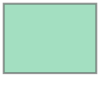

In [20]:
poly_bound

In [23]:
point_interest = Point(-122.5,38)

In [24]:
point_interest.within(poly_bound)

True

In [12]:
# Create Point objects
p1 = Point(24.952242, 60.1696017)
p2 = Point(24.976567, 60.1612500)

# Create a Polygon
coords = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]
poly = Polygon(coords)

In [13]:
p1.within(poly)

True

In [14]:
p2.within(poly)

False

In [33]:
def chk_polygon(pt_lon, pt_lat):
	"""
	This function checks to see if address entered is within the polygon of data the model is trained on
	Input: string
	Output: string, true or false
	"""

	coords = [(-123.5,39), (-119.5,39), (-119.5,36), (-123.5,36),(-123.5,39)]
	poly_bound = Polygon(coords)
	point_interest = Point(pt_lon, pt_lat)
	result = point_interest.within(poly_bound)

	return result

In [36]:
answer = chk_polygon(-122.5,39)

In [45]:
if chk_polygon(-122.5,38):
    print("y")
else:
    phrase = "There is no active fire near this area."

y


In [46]:
phrase

'There is no active fire near this area.'

In [5]:
poly_shape = [[-121.923043159997,36.5243953595764],[-121.895555446772,36.5243953595764],[-121.927624445535,36.5207136879198],[-121.886392875697,36.5207136879198],[-121.927624445535,36.5170318410666],[-121.886392875697,36.5170318410666],[-121.932205731072,36.5133498190239],[-121.872649019084,36.5133498190239],[-121.932205731072,36.5096676217985],[-121.872649019084,36.5096676217985],[-121.932205731072,36.5059852493972],[-121.868067733547,36.5059852493972],[-121.932205731072,36.5023027018269],[-121.868067733547,36.5023027018269],[-121.93678701661,36.4986199790946],[-121.868067733547,36.4986199790946],[-121.93678701661,36.494937081207],[-121.868067733547,36.494937081207],[-121.932205731072,36.4912540081711],[-121.868067733547,36.4912540081711],[-121.932205731072,36.4875707599937],[-121.868067733547,36.4875707599937],[-121.932205731072,36.4838873366818],[-121.858905162472,36.4838873366818],[-121.932205731072,36.4802037382423],[-121.868067733547,36.4802037382423],[-121.932205731072,36.476519964682],[-121.858905162472,36.476519964682],[-121.932205731072,36.4728360160079],[-121.854323876934,36.4728360160079],[-121.932205731072,36.4691518922269],[-121.822254878171,36.4691518922269],[-121.932205731072,36.4654675933458],[-121.813092307096,36.4654675933458],[-121.927624445535,36.4617831193716],[-121.808511021559,36.4617831193716],[-121.932205731072,36.4580984703112],[-121.808511021559,36.4580984703112],[-121.932205731072,36.4544136461716],[-121.803929736021,36.4544136461716],[-121.93678701661,36.4507286469595],[-121.794767164946,36.4507286469595],[-121.950530873222,36.4470434726821],[-121.895555446772,36.4470434726821],[-121.890974161234,36.4470434726821],[-121.886392875697,36.4470434726821],[-121.881811590159,36.4470434726821],[-121.794767164946,36.4470434726821],[-121.950530873222,36.4433581233461],[-121.886392875697,36.4433581233461],[-121.881811590159,36.4433581233461],[-121.790185879409,36.4433581233461],[-121.950530873222,36.4396725989586],[-121.895555446772,36.4396725989586],[-121.881811590159,36.4396725989586],[-121.790185879409,36.4396725989586],[-121.950530873222,36.4359868995264],[-121.785604593871,36.4359868995264],[-121.950530873222,36.4323010250566],[-121.785604593871,36.4323010250566],[-121.950530873222,36.428614975556],[-121.781023308334,36.428614975556],[-121.950530873222,36.4249287510315],[-121.895555446772,36.4249287510315],[-121.872649019084,36.4249287510315],[-121.781023308334,36.4249287510315],[-121.950530873222,36.4212423514902],[-121.895555446772,36.4212423514902],[-121.872649019084,36.4212423514902],[-121.776442022796,36.4212423514902],[-121.950530873222,36.417555776939],[-121.895555446772,36.417555776939],[-121.872649019084,36.417555776939],[-121.776442022796,36.417555776939],[-121.941368302147,36.4138690273849],[-121.900136732309,36.4138690273849],[-121.863486448009,36.4138690273849],[-121.776442022796,36.4138690273849],[-121.932205731072,36.4101821028348],[-121.904718017847,36.4101821028348],[-121.863486448009,36.4101821028348],[-121.776442022796,36.4101821028348],[-121.932205731072,36.4064950032956],[-121.909299303385,36.4064950032956],[-121.863486448009,36.4064950032956],[-121.776442022796,36.4064950032956],[-121.932205731072,36.4028077287743],[-121.909299303385,36.4028077287743],[-121.863486448009,36.4028077287743],[-121.776442022796,36.4028077287743],[-121.923043159997,36.399120279278],[-121.91846187446,36.399120279278],[-121.863486448009,36.399120279278],[-121.776442022796,36.399120279278],[-121.863486448009,36.3954326548135],[-121.776442022796,36.3954326548135],[-121.863486448009,36.3917448553878],[-121.781023308334,36.3917448553878],[-121.863486448009,36.388056881008],[-121.781023308334,36.388056881008],[-121.863486448009,36.3843687316809],[-121.785604593871,36.3843687316809],[-121.863486448009,36.3806804074137],[-121.790185879409,36.3806804074137],[-121.858905162472,36.3769919082132],[-121.794767164946,36.3769919082132],[-121.858905162472,36.3733032340865],[-121.794767164946,36.3733032340865],[-121.858905162472,36.3696143850405],[-121.799348450484,36.3696143850405],[-121.858905162472,36.3659253610823],[-121.799348450484,36.3659253610823],[-121.849742591397,36.3622361622188],[-121.813092307096,36.3622361622188],[-121.831417449246,36.3585467884571],[-121.826836163709,36.3585467884571],[-121.923043159997,36.5243953595764]]

map_output = poly_shape

In [6]:
map_output

[[-121.923043159997, 36.5243953595764],
 [-121.895555446772, 36.5243953595764],
 [-121.927624445535, 36.5207136879198],
 [-121.886392875697, 36.5207136879198],
 [-121.927624445535, 36.5170318410666],
 [-121.886392875697, 36.5170318410666],
 [-121.932205731072, 36.5133498190239],
 [-121.872649019084, 36.5133498190239],
 [-121.932205731072, 36.5096676217985],
 [-121.872649019084, 36.5096676217985],
 [-121.932205731072, 36.5059852493972],
 [-121.868067733547, 36.5059852493972],
 [-121.932205731072, 36.5023027018269],
 [-121.868067733547, 36.5023027018269],
 [-121.93678701661, 36.4986199790946],
 [-121.868067733547, 36.4986199790946],
 [-121.93678701661, 36.494937081207],
 [-121.868067733547, 36.494937081207],
 [-121.932205731072, 36.4912540081711],
 [-121.868067733547, 36.4912540081711],
 [-121.932205731072, 36.4875707599937],
 [-121.868067733547, 36.4875707599937],
 [-121.932205731072, 36.4838873366818],
 [-121.858905162472, 36.4838873366818],
 [-121.932205731072, 36.4802037382423],
 [-1

In [13]:
map_output = read_csv()

In [261]:
if len(geo_center) > 0:
    cnn_poly = convert_polygon(geo_poly)
else:
	phrase = "no active fire"

In [262]:
write_csv(cnn_poly)

In [242]:
geo_center

[-81.218376301, 26.1663754840001]

In [243]:
len(geo_center)

2

In [244]:
geo_poly

[(-81.218376301, 26.1663754840001),
 (-81.218523916, 26.1663752600001),
 (-81.218531151, 26.16629699),
 (-81.218376168, 26.166303885),
 (-81.218376301, 26.1663754840001)]

In [245]:
cnn_poly

[(0.00023505655027221693, -0.0007295970878255902),
 (0.0002350565482599907, -0.0007295984138736967),
 (0.0002350558451486169, -0.0007295984788668077),
 (0.00023505590708745579, -0.000729597086630831),
 (0.00023505655027221693, -0.0007295970878255902)]

# done

In [14]:
def active_fire(lat_origin, lon_origin):
	"""
	Function to find coordinates of active fires of given origin
	Input: latitude, longitude of input address (origin)
	Output: List of active fires within certain miles of origin
	"""

	# set variables
	lat_geo = []
	lon_geo = []
	geo_center = []

	# # read JSON on active fire
	# url = 'https://www.fire.ca.gov/umbraco/api/IncidentApi/List?inactive=true'
	# geo_data = requests.get(url).json()

	# # loop through list provided by Cal Fire and find active fire within certain miles of origin
	# for i in range(0,len(geo_data)):
	#     if geo_data[i]['IsActive'] == "Y":
	#         fire_lat = geo_data[i]['Latitude']
	#         fire_lon = geo_data[i]['Longitude']
	#         dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)
	#         if dist <= 100:
	#         	lat_geo.append(fire_lat)
	#         	lon_geo.append(fire_lon)

	# geo_center = [[a, b] for a, b in zip(lon_geo, lat_geo)]

	# geo_center = [[-121.9230432, 36.52439536]]

	# return geo_center

	# read JSON on active fire
	url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
	# geo_data = requests.get(url).json()	
	geo_data = gpd.read_file(url)

	poly_list = geo_data.geometry

	for i in range(0,len(poly_list)):

		if poly_list[i].geom_type == 'MultiPolygon':

			for j in range(0, len(poly_list[i])):

				geo_poly = points(poly_list[i][j])

				for k in range(0, len(geo_poly)):

					fire_lon = geo_poly[k][0]
					fire_lat = geo_poly[k][1]

					dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

					if dist <= 100:
						geo_center = [fire_lon, fire_lat]
						break

				if len(geo_center) > 0:
					break

			if len(geo_center) > 0:
				break

		else:

			geo_poly = points(poly_list[i])

			for j in range(0, len(geo_poly)):

				fire_lon = geo_poly[j][0]
				fire_lat = geo_poly[j][1]

				dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

				if dist <= 100:
					geo_center = [fire_lon, fire_lat]
					break

			if dist <= 100:
				geo_center = [fire_lon, fire_lat]
				break

		if len(geo_center) > 0:
			break

	return geo_center, geo_poly

In [15]:
geo_center = active_fire(36.543286, -121.929533)

In [16]:
geo_center

([],
 [(-80.556476, 25.6369780000001),
  (-80.556696, 25.6371080000001),
  (-80.556815, 25.6371330000001),
  (-80.5570969999999, 25.637144),
  (-80.557475, 25.637118),
  (-80.55834, 25.636559),
  (-80.558998, 25.636108),
  (-80.560208, 25.635316),
  (-80.560458, 25.635256),
  (-80.560959, 25.6351750000001),
  (-80.561168, 25.635114),
  (-80.561318, 25.6350160000001),
  (-80.561406, 25.6349010000001),
  (-80.5614219999999, 25.634775),
  (-80.561394, 25.6346540000001),
  (-80.561184, 25.634438),
  (-80.5609909999999, 25.6343610000001),
  (-80.560806, 25.634261),
  (-80.560624, 25.6341380000001),
  (-80.5604749999999, 25.6339770000001),
  (-80.560373, 25.6337820000001),
  (-80.56031, 25.6335530000001),
  (-80.5603179999999, 25.6333080000001),
  (-80.560352, 25.633048),
  (-80.560615, 25.6319800000001),
  (-80.560696, 25.6317280000001),
  (-80.560831, 25.6315240000001),
  (-80.561022, 25.631382),
  (-80.561246, 25.6313020000001),
  (-80.561498, 25.6312830000001),
  (-80.561769, 25.631317),

In [17]:
def active_fire(lat_origin, lon_origin):
	"""
	Function to find coordinates of active fires of given origin
	Input: latitude, longitude of input address (origin)
	Output: List of active fires within certain miles of origin
	"""

	# set variables
	lat_geo = []
	lon_geo = []
	geo_center = []
	geo_fire = []

	# # read JSON on active fire
	# url = 'https://www.fire.ca.gov/umbraco/api/IncidentApi/List?inactive=true'
	# geo_data = requests.get(url).json()

	# # loop through list provided by Cal Fire and find active fire within certain miles of origin
	# for i in range(0,len(geo_data)):
	#     if geo_data[i]['IsActive'] == "Y":
	#         fire_lat = geo_data[i]['Latitude']
	#         fire_lon = geo_data[i]['Longitude']
	#         dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)
	#         if dist <= 100:
	#         	lat_geo.append(fire_lat)
	#         	lon_geo.append(fire_lon)

	# geo_center = [[a, b] for a, b in zip(lon_geo, lat_geo)]

	# geo_center = [[-121.9230432, 36.52439536]]

	# return geo_center

	# read JSON on active fire
	url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
	# geo_data = requests.get(url).json()	
	geo_data = gpd.read_file(url)

	poly_list = geo_data.geometry

	# grab the first coordinates of all polygons to create list of active fires

	for m in range(0,len(poly_list)):

		if poly_list[m].geom_type == 'MultiPolygon':

			geo_poly = points(poly_list[m][0])

			fire_lon = geo_poly[0][0]
			fire_lat = geo_poly[0][1]

			lat_geo.append(fire_lat)
			lon_geo.append(fire_lon)

		else:

			geo_poly = points(poly_list[m])

			fire_lon = geo_poly[0][0]
			fire_lat = geo_poly[0][1]

			lat_geo.append(fire_lat)
			lon_geo.append(fire_lon)

	geo_fire = [[a, b] for a, b in zip(lon_geo, lat_geo)]

	geo_poly = []

	for i in range(0,len(poly_list)):

		if len(geo_center) > 0:
			break

		if poly_list[i].geom_type == 'MultiPolygon':

			for j in range(0, len(poly_list[i])):

				geo_poly = points(poly_list[i][j])

				for k in range(0, len(geo_poly)):

					fire_lon = geo_poly[k][0]
					fire_lat = geo_poly[k][1]

					dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

					if dist <= 100:
						geo_center = [fire_lon, fire_lat]
						break

				if len(geo_center) > 0:
					break

			if len(geo_center) > 0:
				break

		else:

			geo_poly = points(poly_list[i])

			for j in range(0, len(geo_poly)):

				fire_lon = geo_poly[j][0]
				fire_lat = geo_poly[j][1]

				dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

				if dist <= 100:
					geo_center = [fire_lon, fire_lat]
					break

			if len(geo_center) > 0:
				break

		if len(geo_center) > 0:
			break
		else:
			geo_poly =[]
			break

	return geo_center, geo_poly, geo_fire

In [18]:
geo_center, geo_poly, geo_fire = active_fire(36.543286, -121.929533)

In [19]:
geo_fire

[[-81.218376301, 26.1663754840001],
 [-119.3058, 43.36044],
 [-81.2211851759999, 25.8929962130001],
 [-81.23895498, 25.8777389570001],
 [-155.822277, 20.026630164],
 [-81.065588147, 26.1690533980001],
 [-119.890105734, 39.586447714],
 [-117.716826787, 40.7578426480001],
 [-117.727254994, 40.856503585],
 [-120.016606534, 39.9634069620001],
 [-109.685227079, 38.815516974],
 [-119.787447749, 39.8127838120001],
 [-119.915611558, 39.7030730540001],
 [-117.614953481, 41.971466923],
 [-78.7591101359999, 38.2392100120001],
 [-118.128895162, 40.445283653],
 [-87.3723336319999, 34.213034613],
 [-84.808704, 30.268151],
 [-122.922469, 39.7514810000001],
 [-94.2877044860817, 34.4447452486556],
 [-118.853425, 43.2886490000001],
 [-77.714422, 34.4719260000001],
 [-83.679064, 37.836416],
 [-86.1041099999999, 33.3485400000001],
 [-111.89324216, 39.97980075],
 [-115.020925524, 36.103205695],
 [-78.48009, 38.5169000000001],
 [-117.8374932, 41.5698244000001],
 [-80.556476, 25.6369780000001]]

In [20]:
len(geo_fire)

29

In [21]:
geo_center

[]

In [123]:
def write_csv(poly, filename):
	"""
	This function writes the active fire intial polygon to csv to be used for the ML model to calculate 
	spread on the next day.
	"""
	# f = open("/static/intial_polygon.csv", "w")
	# f.truncate()
	# f.close()
	filename = filename

	with open(filename, "w") as f:
		writer = csv.writer(f)
		writer.writerows(poly)

In [126]:
write_csv(geo_fire,"static/initial_polygon.csv")

In [10]:
# set variables
lat_geo = []
lon_geo = []
geo_center = []

# read JSON on active fire
url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
# geo_data = requests.get(url).json()	
geo_data = gpd.read_file(url)

poly_list = geo_data.geometry

In [23]:
url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
# geo_data = requests.get(url).json()	
geo_data = gpd.read_file(url)

poly_list = geo_data.geometry

In [12]:
poly_list

0     POLYGON ((-81.21838 26.16638, -81.21852 26.166...
1     POLYGON ((-119.30580 43.36044, -119.30572 43.3...
2     POLYGON ((-81.22119 25.89300, -81.22125 25.892...
3     POLYGON ((-81.23895 25.87774, -81.23895 25.877...
4     POLYGON ((-155.82228 20.02663, -155.82229 20.0...
5     POLYGON ((-81.06559 26.16905, -81.06559 26.169...
6     POLYGON ((-119.89011 39.58645, -119.89014 39.5...
7     POLYGON ((-117.71683 40.75784, -117.71681 40.7...
8     POLYGON ((-117.72725 40.85650, -117.72722 40.8...
9     POLYGON ((-120.01661 39.96341, -120.01656 39.9...
10    POLYGON ((-109.68523 38.81552, -109.68520 38.8...
11    MULTIPOLYGON (((-119.78745 39.81278, -119.7874...
12    POLYGON ((-119.91561 39.70307, -119.91558 39.7...
13    POLYGON ((-117.61495 41.97147, -117.61494 41.9...
14    POLYGON ((-78.75911 38.23921, -78.75914 38.239...
15    POLYGON ((-118.12890 40.44528, -118.12891 40.4...
16    POLYGON ((-87.37233 34.21303, -87.37231 34.213...
17    POLYGON ((-84.80870 30.26815, -84.80886 30

In [21]:
geo_activeloc = points(poly_list[11][0])

In [22]:
geo_activeloc[0][0]

-119.787447749

In [15]:
len(poly_list)

27

In [24]:
geo_poly = points(poly_list[0])

In [25]:
geo_poly

[(-81.218376301, 26.1663754840001),
 (-81.218523916, 26.1663752600001),
 (-81.218531151, 26.16629699),
 (-81.218376168, 26.166303885),
 (-81.218376301, 26.1663754840001)]

In [26]:
cnn_poly = convert_polygon(geo_poly)

In [27]:
cnn_poly

[(0.00023505655027221693, -0.0007295970878255902),
 (0.0002350565482599907, -0.0007295984138736967),
 (0.0002350558451486169, -0.0007295984788668077),
 (0.00023505590708745579, -0.000729597086630831),
 (0.00023505655027221693, -0.0007295970878255902)]

In [22]:
with open("static/intial_polygon.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(cnn_poly)

In [24]:
len(geo_poly)

5

In [ ]:
for i in range(0,len(poly_list)):

    if poly_list[i].geom_type == 'MultiPolygon':

        for j in range(0, len(poly_list[i])):

            geo_poly = points(poly_list[i][j])

            for k in range(0, len(geo_poly)):

                fire_lon = geo_poly[k][0]
                fire_lat = geo_poly[k][1]

                dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

                if dist <= 100:
                    geo_center = [fire_lon, fire_lat]
                    break

            if len(geo_center) > 0:
                break

        if len(geo_center) > 0:
            break

    else:

        geo_poly = points(poly_list[i])

        for j in range(0, len(geo_poly)):

            fire_lon = geo_poly[j][0]
            fire_lat = geo_poly[j][1]

            dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

            if dist <= 100:
                geo_center = [fire_lon, fire_lat]
                break
                
        if dist <= 100:
            geo_center = [fire_lon, fire_lat]
            break

    if len(geo_center) > 0:
        break

In [13]:
def fire_map():

	geo_center = []
	add_loc = []

	address = "Berkeley, CA"
# 	if request.method == "POST":
# 		address = str(request.form["address"])
	
	add_lat, add_lon = get_lat_loc(address)
	
	geo_center = active_fire(add_lat, add_lon)

	# for i in range(0, len(geo_center)):
	geo_lat = geo_center[1]
	geo_lon = geo_center[0]
	crs = convert_point(geo_lat, geo_lon)

	map_output = read_csv()

In [ ]:
fire_map()

In [ ]:
# set variables
lat_geo = []
lon_geo = []
geo_center = []

url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
# geo_data = requests.get(url).json()	
geo_data = gpd.read_file(url)

poly_list = geo_data.geometry

for i in range(0,len(poly_list)):

    if len(geo_center) > 0:
        break

    if poly_list[i].geom_type == 'MultiPolygon':

        for j in range(0, len(poly_list[i])):

            geo_poly = points(poly_list[i][j])

            for k in range(0, len(geo_poly)):

                fire_lon = geo_poly[k][0]
                fire_lat = geo_poly[k][1]

                dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

                if dist <= 100:
                    geo_center = [fire_lon, fire_lat]
                    break

            if len(geo_center) > 0:
                break

        if len(geo_center) > 0:
            break

    else:

        geo_poly = points(poly_list[i])

        for j in range(0, len(geo_poly)):

            fire_lon = geo_poly[j][0]
            fire_lat = geo_poly[j][1]

            dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)

            if dist <= 100:
                geo_center = [fire_lon, fire_lat]
                break

        if len(geo_center) > 0:
            break

    if len(geo_center) > 0:
        break

return geo_center, geo_poly

In [50]:
lat_geo = []
lon_geo = []
geo_fire = []

# list of the States in USA
states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','South Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']

# read JSON on active fire
url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
# geo_data = requests.get(url).json()	
geo_data = gpd.read_file(url)

poly_list = geo_data.geometry

# grab the first coordinates of all polygons to create list of active fires

for m in range(0,len(poly_list)):

    if poly_list[m].geom_type == 'MultiPolygon':

        geo_poly = points(poly_list[m][0])

        fire_lon = geo_poly[0][0]
        fire_lat = geo_poly[0][1]

        lat_geo.append(fire_lat)
        lon_geo.append(fire_lon)

    else:

        geo_poly = points(poly_list[m])

        fire_lon = geo_poly[0][0]
        fire_lat = geo_poly[0][1]

        lat_geo.append(fire_lat)
        lon_geo.append(fire_lon)

geo_fire = [[a, b] for a, b in zip(lon_geo, lat_geo)]

# 
fire_names = geo_data.IncidentName
acres = geo_data.GISAcres

geocoder = mapbox.Geocoder(access_token = MAPBOX_ACCESS_KEY)

loc_output = []
state_output = []

for l in range(0,len(geo_fire)):

    rev_lon = geo_fire[l][0]
    rev_lat = geo_fire[l][1]

    response = geocoder.reverse(lon=rev_lon, lat=rev_lat)

    features = response.geojson()['features']

    loc_name = features[0]["place_name"]

    loc_output.append(loc_name)

    res = re.findall(r'\w+', loc_name)

    for s in range(0,len(res)):
        if res[s] in states:
            state_output.append(res[s])
            break

firename = []

for f in range(0,len(fire_names)):
    firename.append(fire_names[f])

fireacre = []

for a in range(0,len(acres)):
    fireacre.append(acres[a])

In [51]:
fire_names

0                 4 Corners
1              Carbon Black
2        Fierce Ridge Fire 
3                      Moon
4                   VANILLA
5                 Old Tyler
6                GRASS PINK
7                  Car Fire
8            Kalaupapa Fire
9                     GHOST
10                Poeville 
11                    Harry
12            Mullen Canyon
13                  Ash Pit
14              Salt Valley
15                Ruby Hill
16                  Redrock
17                 Riverbed
18    FURNACE MOUNTAIN FIRE
19                    Vista
20            BK MOODY BEND
21                    Vilas
22                 BASEBALL
23          Little Mountain
24                 Sodhouse
25    Tram Road-Grassy Road
26            Haystack Rock
27                   TL 617
28               Goshen Bay
29          Wetlands CCFD 2
30       TANNERS RIDGE FIRE
31             South Valley
32                  40 mile
33             Narrow Ditch
34                     Jack
35        PORTER RID

In [52]:
acres

0        1.252288
1       91.815121
2        0.883646
3        0.355791
4        0.030997
5      132.978310
6        0.097024
7        0.292332
8       20.332094
9        0.218116
10      68.784206
11      58.016912
12       0.286968
13      13.284521
14      20.114628
15       0.497999
16       0.229318
17       1.482773
18       1.759678
19       1.567525
20      11.933328
21    7492.573491
22      82.875856
23      24.985175
24     827.505655
25    2511.753786
26      13.871382
27      20.660229
28       5.779676
29      19.376973
30      23.995488
31       0.780783
32      10.900085
33     800.388732
34       8.966386
35       5.090159
36      36.299832
37       0.012147
38      17.424121
Name: GISAcres, dtype: float64

In [53]:
loc_output

['Norris, South Dakota 57560, United States',
 'Fm 1559, Borger, Texas 79007, United States',
 '19625 Township Highway 346, Glouster, Ohio 45732, United States',
 'Big Foot Trail, Kyle, South Dakota 57752, United States',
 'Alligator Alley, Ochopee, Florida 34141, United States',
 'Double O Road, Princeton, Oregon 97721, United States',
 '18400 Burns Road, Ochopee, Florida 34141, United States',
 '44100 Tamiami Trail, Ochopee, Florida 34141, United States',
 'Ala Kahakai National Historic Trail, Kamuela, Hawaii 96743, United States',
 'Alligator Alley, Ochopee, Florida 34141, United States',
 'Reno, Nevada 89506, United States',
 'Grass Valley Road, Winnemucca, Nevada 89445, United States',
 '0 T34 R38 Sec 5, Winnemucca, Nevada 89445, United States',
 'Homestead Ranch Road, Doyle, California 96109, United States',
 'Salt Valley Road, Moab, Utah 84532, United States',
 'Prospect Hill Road, Reno, Nevada 89510, United States',
 'County Road 161, Reno, Nevada 89508, United States',
 'North

In [55]:
loc_output[0]

'Norris, South Dakota 57560, United States'

In [57]:
res = re.findall(r'\w+', loc_output[0])

for s in range(0,len(res)):
    if res[s] in states:
        state_output.append(res[s])
        break

In [59]:
res

['Norris', 'South', 'Dakota', '57560', 'United', 'States']

In [58]:
state_output

['Texas',
 'Ohio',
 'Florida',
 'Oregon',
 'Florida',
 'Florida',
 'Hawaii',
 'Florida',
 'Nevada',
 'Nevada',
 'Nevada',
 'California',
 'Utah',
 'Nevada',
 'Nevada',
 'Nevada',
 'Virginia',
 'Nevada',
 'Alabama',
 'Florida',
 'California',
 'Arkansas',
 'Oregon',
 'Kentucky',
 'Alabama',
 'Utah',
 'Nevada',
 'Virginia',
 'Nevada',
 'Montana',
 'Florida',
 'Nevada',
 'Washington',
 'Wyoming',
 'Wyoming',
 'Minnesota']

In [65]:
res1 = loc_output[0].split(",")

In [66]:
res1

['Norris', ' South Dakota 57560', ' United States']

In [89]:
lres = []
stateoutput = []

for s in range(0,len(res1)):
    a = res1[s]
    result = re.sub(r'[0-9]+', '',a)
    result1 = result.strip()
    if result1 in states:
        stateoutput.append(result1)
        break

In [90]:
res1

['Norris', ' South Dakota 57560', ' United States']

In [91]:
result

' South Dakota '

In [92]:
stateoutput

['South Dakota']

In [67]:
res2 = re.findall(r'\w+', res1)

TypeError: expected string or bytes-like object